In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
import math

In [12]:
def SIR_birthdeath(S0,I0,R0, beta, gamma, mu, t_max, stepsize):
    T = np.arange(0,t_max+stepsize,stepsize)
    S = np.zeros(len(T))
    I = np.zeros(len(T))
    R = np.zeros(len(T))
    N = S0+I0+R0
    
    for idx,t in enumerate(T):
        if idx==0:
            S[idx] = S0
            I[idx] = I0
            R[idx] = R0
        else:
            dS_dt = -beta * S[idx-1] * I[idx-1] / N - mu*S[idx-1] + mu*N
            dI_dt = beta * S[idx-1] * I[idx-1] / N - gamma * I[idx-1] - mu*I[idx-1]
            dR_dt = gamma * I[idx-1] - mu*R[idx-1]
            
            S[idx] = S[idx-1] + dS_dt * stepsize
            I[idx] = I[idx-1] + dI_dt * stepsize
            R[idx] = R[idx-1] + dR_dt * stepsize
    
    return S, I, R, T

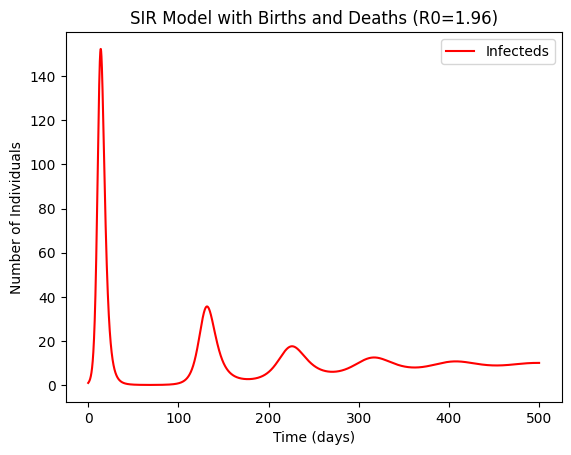

In [13]:
# SIR(S0,I0,R0, beta, gamma, t_max, stepsize):
fig, ax = plt.subplots()
beta = 1
gamma = 0.5
mu = 0.01
max_t = 500

S,I,R,T = SIR_birthdeath(999,1,0,
             beta,gamma,mu,max_t,0.05)
# ax.plot(T,S, color='b', label='Susceptibles')
ax.plot(T,I, color='r', label='Infecteds')
# ax.plot(T,R, color='k', label='Recovereds')
R0 = beta/(gamma+mu)
Seq = 1/R0 * 1000
# ax.plot([0,max_t],[Seq,Seq],'b--')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of Individuals')
ax.set_title(f'SIR Model with Births and Deaths (R0={R0:.2f})')
ax.legend()
plt.show()

Selected window: weeks 5-14
slope = 0.4551 per week  (95% CI: 0.4199, 0.4904)  | R² = 0.9911
R0 = 1.892  (95% CI: 1.823, 1.962)
(gamma=0.50 per week, mu=0.01 per week, gamma+mu=0.51 per week)


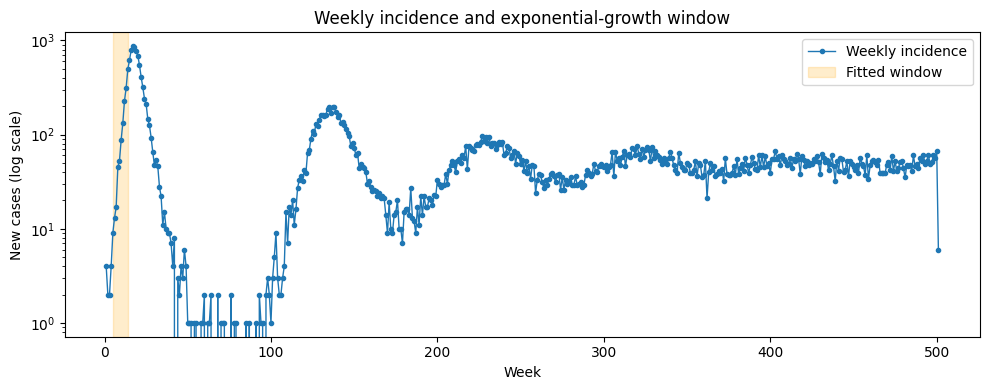

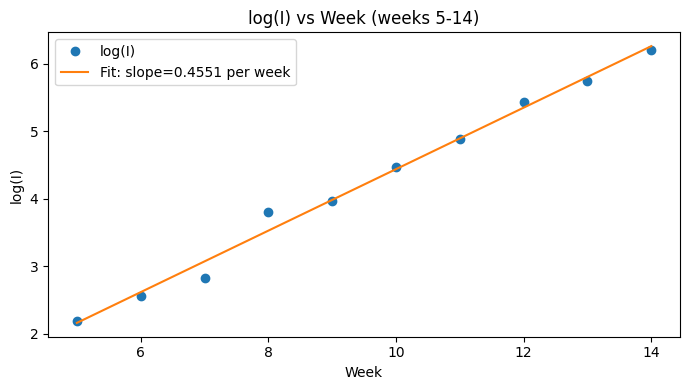

In [14]:
## loading in weekly incidence data
## fitting log(I) vs t (days) to get the slope with 95% confidence intervals
path = Path('HW4_all_weeks.csv')
df = pd.read_csv(path).rename(columns={'New Cases': 'NewCases'})
df["logI"] = np.log(df["NewCases"].replace(0, np.nan))

gamma = 1/2 # recovery rate (1/num_days infectious) in the case of BRUH, the infectious period lasts 14 days (2 weeks)
mu = 1/100 # average lifespan of 700 days (100 weeks)
rate_scale = gamma + mu # removal rate per week

def fit_log_linear(df_slice):
    """
    Function to fit log(I) vs Week using OLS regression.
    The input df_slice should have the columns 'Week' and 'logI'.
    It returns the fitted regression results.
    """
    y = df_slice["logI"].values
    x = sm.add_constant(df_slice["Week"].values)
    return sm.OLS(y, x, missing='drop').fit()

def auto_find_growth_window(df, search_end_week=40, min_len=8, max_len=18):
    """
    This function scans through possible time windows using the sliding window approach.
    The input df should contain columns for 'Week' and 'NewCases'.
    It will return the best-fitting window (start week, end week) and the regression results for it.
    
    """
    best = None
    weeks = df["Week"].values
    wmin, wmax = int(weeks.min()), int(min(search_end_week, weeks.max()))
    for start in range(wmin, wmax - min_len + 2):
        for end in range(start + min_len - 1, min(start + max_len - 1, wmax) + 1):
            df_slice = df[(df["Week"] >= start) & (df["Week"] <= end)]
            if (df_slice["NewCases"] <= 0).any():  # avoid zeros in log
                continue
            res = fit_log_linear(df_slice)
            slope = res.params[1]
            if slope <= 0:
                continue
            score = res.rsquared
            if (best is None) or (score > best["rsq"]):
                best = {"start": start, "end": end, "res": res, "rsq": score}
    return best

# can also set a fixed window; otherwise leaving as None defaults to automatic selection
start_week = None  # e.g., 8
end_week = None    # e.g., 16

if start_week is None or end_week is None:
    best = auto_find_growth_window(df, search_end_week=40, min_len=9, max_len=18)
    if best is None:
        raise RuntimeError("No suitable exponential-growth window found without zeros.")
    start_week, end_week, res = best["start"], best["end"], best["res"]
else:
    df_slice = df[(df["Week"] >= start_week) & (df["Week"] <= end_week)]
    if (df_slice["NewCases"] <= 0).any():
        raise ValueError("Selected window contains zeros; choose a window with positive incidence.")
    res = fit_log_linear(df_slice)

slope = res.params[1]  # per week
# robustly extract 95% CI whether conf_int() returns ndarray or DataFrame
ci = res.conf_int()
if isinstance(ci, np.ndarray):
    slope_ci_low, slope_ci_high = ci[1].tolist()
else:
    slope_ci_low, slope_ci_high = ci.iloc[1].tolist()
r2 = res.rsquared

R0_hat = slope / rate_scale + 1
R0_ci = (slope_ci_low / rate_scale + 1, slope_ci_high / rate_scale + 1)

print(f"Selected window: weeks {start_week}-{end_week}")
print(f"slope = {slope:.4f} per week  (95% CI: {slope_ci_low:.4f}, {slope_ci_high:.4f})  | R² = {r2:.4f}")
print(f"R0 = {R0_hat:.3f}  (95% CI: {R0_ci[0]:.3f}, {R0_ci[1]:.3f})")
print(f"(gamma={gamma:.2f} per week, mu={mu:.2f} per week, gamma+mu={rate_scale:.2f} per week)")

# plot full series on log scale and highlight fitted window
plt.figure(figsize=(10,4))
plt.semilogy(df["Week"], df["NewCases"], marker='o', lw=1, ms=3, label="Weekly incidence")
plt.axvspan(start_week, end_week, color="orange", alpha=0.2, label="Fitted window")
plt.xlabel("Week"); plt.ylabel("New cases (log scale)")
plt.title("Weekly incidence and exponential-growth window")
plt.legend(); plt.tight_layout(); plt.show()

# plot log(I) vs week with fitted line
df_slice = df[(df["Week"] >= start_week) & (df["Week"] <= end_week)].copy()
x = df_slice["Week"].values
y = df_slice["logI"].values
a, b = res.params  # intercept, slope
plt.figure(figsize=(7,4))
plt.plot(x, y, 'o', label="log(I)")
plt.plot(x, a + b*x, '-', label=f"Fit: slope={b:.4f} per week")
plt.xlabel("Week"); plt.ylabel("log(I)")
plt.title(f"log(I) vs Week (weeks {start_week}-{end_week})")
plt.legend(); plt.tight_layout(); plt.show()

Seroprevalence-based R0:
  p_s = 0.517, 95% CI [0.486, 0.548]
  R0  = 2.070, 95% CI [1.95, 2.21]


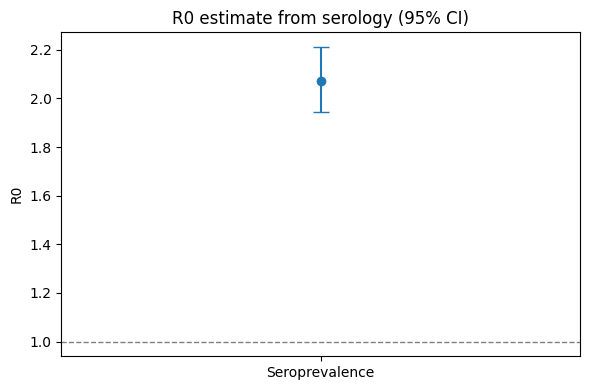

In [15]:
Z = 1.96  # 95% CI

def wilson_ci(k, n, z=Z):
    if n == 0:
        return (0.0, 0.0)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    half = z * math.sqrt(p*(1-p)/n + z**2/(4*n**2)) / denom
    return max(0.0, center - half), min(1.0, center + half)

# what we know
L = 100.0  # weeks
D = 2.0    # weeks
mu = 1.0 / L
gamma = 1.0 / D
factor = (gamma + mu) / mu  # = 51

# seroprevalence data
n_sero, k_sero = 1000, 517
p_sero = k_sero / n_sero
lo_s, hi_s = wilson_ci(k_sero, n_sero)

R0_sero = 1.0 / (1.0 - p_sero)
R0_sero_lo = 1.0 / (1.0 - lo_s)
R0_sero_hi = 1.0 / (1.0 - hi_s)

print("Seroprevalence-based R0:")
print(f"  p_s = {p_sero:.3f}, 95% CI [{lo_s:.3f}, {hi_s:.3f}]")
print(f"  R0  = {R0_sero:.3f}, 95% CI [{R0_sero_lo:.2f}, {R0_sero_hi:.2f}]")

# plot
label = ["Seroprevalence"]
x = [0]
y = [R0_sero]
low = R0_sero - R0_sero_lo
high = R0_sero_hi - R0_sero

plt.figure(figsize=(6,4))
plt.errorbar(x, y, yerr=[[low], [high]], fmt='o', capsize=6)
plt.axhline(1.0, color='gray', lw=1, ls='--')
plt.xticks(x, label, rotation=0)
plt.ylabel("R0")
plt.title("R0 estimate from serology (95% CI)")
plt.tight_layout()
plt.savefig("r0_from_sero.png", dpi=150)
plt.show()

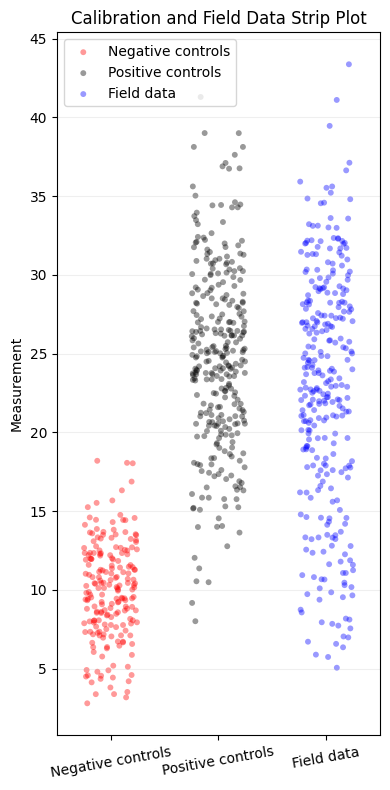

In [28]:
neg = pd.read_csv("HW4_Q3_neg-1.csv", header=None, names=["value"])
pos = pd.read_csv("HW4_Q3_pos-1.csv", header=None, names=["value"])
fld = pd.read_csv("HW4_Q3_data-1.csv", header=None, names=["value"])

groups = [
    ("Negative controls", "red", neg["value"].values),
    ("Positive controls", "black", pos["value"].values),
    ("Field data", "blue", fld["value"].values),
]

# Jittered scatter (strip) plot
np.random.seed(42)
plt.figure(figsize=(4, 8))  # tall, skinny
width = 0.25  # horizontal jitter width

for i, (label, color, values) in enumerate(groups, start=1):
    x = np.random.uniform(i - width, i + width, size=len(values))
    plt.scatter(x, values, color=color, alpha=0.4, s=18, edgecolors="none", label=label)

plt.xticks([1, 2, 3], [g[0] for g in groups], rotation=10)
plt.xlim(0.5, 3.5)
plt.ylabel("Measurement")
plt.title("Calibration and Field Data Strip Plot")
plt.legend(loc="upper left")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.savefig("q3a_controls_field_stripplot.png", dpi=150, bbox_inches="tight")
plt.show()

In [22]:
# Load (reload to be self-contained)
neg = pd.read_csv("HW4_Q3_neg-1.csv", header=None, names=["value"])["value"].values
pos = pd.read_csv("HW4_Q3_pos-1.csv", header=None, names=["value"])["value"].values
field_data = pd.read_csv("HW4_Q3_data-1.csv", header=None, names=["value"])["value"].values

def se(c):
    return np.mean(pos >= c)

def sp(c):
    return np.mean(neg < c)

def phi_hat(c):
    return np.mean(field_data >= c)

def theta_hat(c):
    sens = se(c)
    spec = sp(c)
    phi = phi_hat(c)
    denom = sens + spec - 1.0
    if denom == 0:
        return np.nan
    theta = (phi - (1 - spec)) / denom  # (phi - (1 - specificity)) / (sensitivity + specificity - 1)
    return np.clip(theta, 0.0, 1.0)

# Youden index J(c) = se(c) + sp(c) - 1; choose c maximizing J
cal = np.sort(np.unique(np.concatenate([neg, pos])))
# candidate cutoffs: below min, midpoints between consecutive calibration values, above max
candidates = [cal[0] - 1e-6] + [(cal[i] + cal[i+1]) / 2 for i in range(len(cal) - 1)] + [cal[-1] + 1e-6]

J_values = np.array([se(c) + sp(c) - 1 for c in candidates])
J_max = J_values.max()
best_indices = np.where(J_values == J_max)[0]
# If multiple, take median candidate
youden_c = float(np.median(np.array(candidates)[best_indices]))

print(f"Youden cutoff c = {youden_c:.4f}")
print(f"Sensitivity se(c) = {se(youden_c):.4f}")
print(f"Specificity sp(c) = {sp(youden_c):.4f}")
print(f"Raw prevalence phi_hat(c) = {phi_hat(youden_c):.4f}")
print(f"Corrected prevalence theta_hat(c) = {theta_hat(youden_c):.4f}")
print(f"Youden index J(c) = {J_max:.4f}")

Youden cutoff c = 14.9197
Sensitivity se(c) = 0.9600
Specificity sp(c) = 0.9600
Raw prevalence phi_hat(c) = 0.8067
Corrected prevalence theta_hat(c) = 0.8333
Youden index J(c) = 0.9200
